In [1]:
%matplotlib inline

In [2]:
import json
import string
import datetime
import requests
import tldextract
import matplotlib
import urlexpander

import scipy.stats

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [35]:
import sklearn.preprocessing
import sklearn.metrics

In [3]:
# Convert JSON to a dict, returning None on fail for filtering
def json_str_to_reddit_sub(json_str):
    submission = None
    try:
        submission = json.loads(json_str)
        
        # Throw away comments. All submissions should have an is_self field
        if ( "is_self" not in submission ):
            submission = None
    except:
        pass
    
    return submission

# Extract TLDs
def custom_tld_extract(link):
    fqdn = tldextract.extract(link).fqdn
    if ( fqdn.startswith("www.") ):
        fqdn = fqdn[4:]
    return fqdn

In [4]:
# Only keep submissions posted between these limits
end_limit = datetime.datetime(2017, 1, 1)
start_limit = datetime.datetime(2015, 1, 1)

def time_filter(submission):
    created_time = submission["created_utc"]
    if ( isinstance(created_time, str) ):
        created_time = int(created_time)
        
    d = datetime.datetime.utcfromtimestamp(created_time)
    return (d >= start_limit and d < end_limit)

In [5]:
row_header = ["reddit_id", "user_name", "created_at", "link"]

In [6]:
# remove self posts, so return true IF THIS IS NOT A SELF POST
def filter_self_text(sub):
    return not sub["is_self"]

# extract links from submission
#   row: submission id, user id, creation date, short link
def submission_to_row(sub):
    sub_id = sub["id"]
    user_id = sub["author"]
    created_at = sub["created_utc"]
    if ( isinstance(created_at, str) ):
        created_at = int(created_at)
        
    link = ""
    if ( not sub["is_self"] ):
        link = sub["url"]
        
    return (sub_id, user_id, created_at, link)

# Given a URL, check to see if it is
#. a shortened URL and unroll if so
def unshorten_urls(url):
    
    unrolled_url = url
    if ( urlexpander.is_short(url) ):
        unrolled_url = urlexpander.expand([url])[0]
        
    tld = urlexpander.get_domain(unrolled_url)

    return (url, (unrolled_url, tld))

In [7]:
# Read submissions, remove duplicates, and filter by time and self-text
random_sample_rows_rdd = sc.textFile("usertimeline/reddit_random_sample")\
    .map(json_str_to_reddit_sub)\
    .filter(lambda t: t is not None)\
    .filter(time_filter)\
    .filter(filter_self_text)\
    .map(lambda sub: (sub["id"], sub))\
    .reduceByKey(lambda l, r: r)\
    .map(lambda tup: tup[1])\
    .map(submission_to_row)

political_sample_rows_rdd = sc.textFile("usertimeline/reddit_political_sample")\
    .map(json_str_to_reddit_sub)\
    .filter(lambda t: t is not None)\
    .filter(time_filter)\
    .filter(filter_self_text)\
    .map(lambda sub: (sub["id"], sub))\
    .reduceByKey(lambda l, r: r)\
    .map(lambda tup: tup[1])\
    .map(submission_to_row)

troll_sample_rows_rdd = sc.textFile("reddit_troll_submissions")\
    .map(json_str_to_reddit_sub)\
    .filter(lambda t: t is not None)\
    .filter(time_filter)\
    .filter(filter_self_text)\
    .map(lambda sub: (sub["id"], sub))\
    .reduceByKey(lambda l, r: r)\
    .map(lambda tup: tup[1])\
    .map(submission_to_row)

random_sample_rows = random_sample_rows_rdd.collect()
political_sample_rows = political_sample_rows_rdd.collect()
troll_sample_rows = troll_sample_rows_rdd.collect()

random_sample_urls = {row[3] for row in random_sample_rows}
political_sample_urls = {row[3] for row in political_sample_rows}
troll_sample_urls = {row[3] for row in troll_sample_rows}

unique_urls = random_sample_urls.union(political_sample_urls).union(troll_sample_urls)

print("Unique URLs to Test:", len(unique_urls))

Unique URLs to Test: 515945


In [8]:
unshortened_urls = sc.parallelize(unique_urls, 256).map(unshorten_urls).collect()
unshortened_urls_map = dict(unshortened_urls)

short_list = [utup for utup in unshortened_urls if utup[0] != utup[1][0]]

print("Shortened URLs:", len(short_list))
print("Percent of URLs that are Short:", len(short_list) / len(unshortened_urls))

Shortened URLs: 88
Percent of URLs that are Short: 0.0001705608155908091


In [9]:
with open("reddit_unshortened_urls.json", "w") as out_file:
    json.dump(unshortened_urls_map, out_file)

In [10]:
unshortened_urls_map = None
with open("reddit_unshortened_urls.json", "r") as in_file:
    unshortened_urls_map = json.load(in_file)

In [11]:
# For eac sample, join the unshortened URLs
for filename, sample in [
    ("reddit_random_links.csv", random_sample_rows),
    ("reddit_political_links.csv", political_sample_rows),
    ("reddit_troll_links.csv", troll_sample_rows),
]:

    print(filename, "Row Count:", len(sample))

    reddit_links_df = pd.DataFrame(sample, columns=row_header)

    reddit_links_df["unshortened"] = reddit_links_df["link"].apply(lambda url: unshortened_urls_map[url][0])
    reddit_links_df["tld"] = reddit_links_df["link"].apply(lambda url: unshortened_urls_map[url][1])

    reddit_links_df.to_csv(filename, index=False)

reddit_random_links.csv Row Count: 114312
reddit_political_links.csv Row Count: 469771
reddit_troll_links.csv Row Count: 12915


# Resume Here

In [7]:
reddit_random_links_df = pd.read_csv("reddit_random_links.csv")
reddit_political_links_df = pd.read_csv("reddit_political_links.csv")
reddit_troll_links_df = pd.read_csv("reddit_troll_links.csv")

In [13]:
reddit_random_links_df.groupby("tld").count().sort_values(by="link", ascending=False)[:10]

,reddit_id,user_name,created_at,link,unshortened
tld,,,,,
imgur.com,30986,30986,30986,30986,30986
youtube.com,13623,13623,13623,13623,13623
redd.it,9785,9785,9785,9785,9785
youtu.be,4938,4938,4938,4938,4938
wordpress.com,2812,2812,2812,2812,2812
reddituploads.com,2423,2423,2423,2423,2423
fitnesstwist.org,2334,2334,2334,2334,2334
themoviewaffler.com,1942,1942,1942,1942,1942
twitter.com,1929,1929,1929,1929,1929


In [14]:
reddit_political_links_df.groupby("tld").count().sort_values(by="link", ascending=False)[:10]

,reddit_id,user_name,created_at,link,unshortened
tld,,,,,
imgur.com,64800,64800,64800,64800,64800
youtube.com,38549,38549,38549,38549,38549
redd.it,24149,24149,24149,24149,24149
twitter.com,13825,13825,13825,13825,13825
reddit.com,12926,12926,12926,12926,12926
youtu.be,10468,10468,10468,10468,10468
nytimes.com,8122,8122,8122,8122,8122
washingtonpost.com,7759,7759,7759,7759,7759
theringer.com,7089,7089,7089,7089,7089


In [15]:
reddit_troll_links_df.groupby("tld").count().sort_values(by="link", ascending=False)[:10]

,reddit_id,user_name,created_at,link,unshortened
tld,,,,,
imgur.com,3991,3991,3991,3991,3991
blackmattersus.com,1207,1207,1207,1207,1207
donotshoot.us,531,531,531,531,531
butthis.com,193,193,193,193,193
nytimes.com,191,191,191,191,191
cnn.com,185,185,185,185,185
theguardian.com,181,181,181,181,181
foxnews.com,176,176,176,176,176
huffingtonpost.com,163,163,163,163,163


In [8]:
# mediascores_df = pd.read_csv("/scratch/olympus/projects/russian_manipulation/yt/media/mediascores.csv")

mediascores_df = pd.read_csv("/scratch/olympus/projects/russian_manipulation/yt/media/DomainIdeology.csv")
mediascores_df["media_org"] = mediascores_df["domain"].apply(str.lower)

In [9]:
# found_tlds = {tup[1][1] for tup in unshortened_urls}
# print("Unique TLDs:", len(found_tlds))

In [10]:
g1 = reddit_random_links_df.groupby("tld").count().sort_values(by="link", ascending=False)[:100].index
g2 = reddit_political_links_df.groupby("tld").count().sort_values(by="link", ascending=False)[:100].index
g3 = reddit_troll_links_df.groupby("tld").count().sort_values(by="link", ascending=False)[:100].index

top_tlds = set(g1).union(set(g2)).union(set(g3))

In [11]:
print("Missing TLDs:")
for missing_tld in sorted(top_tlds.difference(set(mediascores_df.media_org))):
    print(missing_tld)

Missing TLDs:
247sports.com
500px.org
9cache.com
abc.net.au
aljazeera.com
amazon.com
ap.org
apkadsense.com
apnewsarchive.com
archive.is
arstechnica.com
atlantablackstar.com
bandcamp.com
bbc.co.uk
bbc.com
befitness.pro
blackmattersus.com
blacktolive.org
blinkfitnessnyc.com
blogspot.com
blogspot.com.au
blogspot.it
boingboing.net
bos303.com
butthis.com
buzzfeed.com
cbc.ca
cbslocal.com
chicagotribune.com
coinpupil.com
conspiracydailyupdate.com
countercurrentnews.com
counterpunch.org
cracked.com
dailymail.co.uk
dailyscoopjournal.com
dashburst.com
derpicdn.net
desmoinesregister.com
detroitsportsnation.com
deviantart.com
deviantart.net
donotshoot.us
dw.com
eroshare.com
eurekalert.org
exoticcarlist.com
express.co.uk
facebook.com
fbcdn.net
fee.org
firstlook.org
fitnessgo.club
fitnesstwist.me
fitnesstwist.org
flickr.com
flipboard.com
france24.com
freebookbay.com
gfycat.com
gifsound.com
giphy.com
go.com
google.com
goutsa.com
gyazo.com
heatst.com
hollynbolly.com
hollywoodreporter.com
imgflip.com
i

In [12]:
mediascores_map = {}
for idx, row in mediascores_df.iterrows():
    mediascores_map[row["media_org"]] = row["zeta"]
    
# Update media scores with shortened domain names
mediascores_map["nyti.ms"] =  mediascores_map["nytimes.com"]
mediascores_map["wpo.st"] =  mediascores_map["washingtonpost.com"]
mediascores_map["wapo.st"] =  mediascores_map["washingtonpost.com"]
mediascores_map["reut.rs"] =  mediascores_map["reuters.com"]
mediascores_map["politi.co"] =  mediascores_map["politico.com"]
mediascores_map["nbcnews.to"] =  mediascores_map["nbcnews.com"]
mediascores_map["n.pr"] =  mediascores_map["npr.org"]
mediascores_map["fxn.ws"] =  mediascores_map["foxnews.com"]
mediascores_map["cnn.it"] =  mediascores_map["cnn.com"]
mediascores_map["bloom.bg"] =  mediascores_map["bloomberg.com"]
mediascores_map["abcn.ws"] =  mediascores_map["abcnews.go.com"]

short_tld_to_long = {
    "nyti.ms": "nytimes.com",
    "wpo.st": "washingtonpost.com",
    "wapo.st": "washingtonpost.com",
    "reut.rs": "reuters.com",
    "politi.co": "politico.com",
    "nbcnews.to": "nbcnews.com",
    "n.pr": "npr.org",
    "fxn.ws": "foxnews.com",
    "cnn.it": "cnn.com",
    "bloom.bg": "bloomberg.com",
    "abcn.ws": "abcnews.go.com",
}

In [13]:
scored_random_links_df = reddit_random_links_df[reddit_random_links_df['tld'].isin(mediascores_map)].copy()
scored_random_links_df["zeta"] = scored_random_links_df["tld"].apply(mediascores_map.get)

scored_political_links_df = reddit_political_links_df[reddit_political_links_df['tld'].isin(mediascores_map)].copy()
scored_political_links_df["zeta"] = scored_political_links_df["tld"].apply(mediascores_map.get)

scored_troll_links_df = reddit_troll_links_df[reddit_troll_links_df['tld'].isin(mediascores_map)].copy()
scored_troll_links_df["zeta"] = scored_troll_links_df["tld"].apply(mediascores_map.get)


In [14]:
# CB-20181119: This bucketing is used in v1.1 of the paper
# def bins(score):
#     if score <= -.3:
#         return 'Liberal'
#     elif score >= 0.3:
#         return 'Conservative'
#     else: #if score <= 0.25:
#         return 'Moderate'

# CB-20190104: This function has been superseded by below
# def ideology_bins(score):
#     if score < -0.2741245: # Less than NYTimes
#         return 'Liberal'
#     elif score > 0.9480055: # Greater than WSJ
#         return 'Conservative'
#     else:
#         return 'Moderate'
    
# CB-20190104: Using new numbers from Greg's scoring
left_cutoff = "washingtonpost.com" # "nytimes.com"
right_cutoff = "wsj.com"
def ideology_bins(score):
    if score < mediascores_map[left_cutoff]: # Less than NYTimes or WaPo
        return 'Liberal'
    elif score > mediascores_map[right_cutoff]: # Greater than WSJ
        return 'Conservative'
    else:
        return 'Moderate'
    
print("Moderate Between:", mediascores_map[left_cutoff], mediascores_map[right_cutoff])

Moderate Between: -0.433091191678776 0.666205716457322


In [15]:
def convert_date(date_stamp):
    created_time = date_stamp
    if ( isinstance(created_time, str) ):
        created_time = int(created_time)
        
    d = datetime.datetime.utcfromtimestamp(created_time)
    return d

In [16]:
for df in [scored_random_links_df, scored_political_links_df, scored_troll_links_df]:
    df["ideology"] = df["zeta"].apply(ideology_bins)
    df['date'] = df['created_at'].apply(convert_date)

In [17]:
color_map = {
    "Liberal": "blue", 
    "Moderate": "lightgrey", 
    "Conservative": "red",
    "Libertarian": "palegreen",
}

cmap_ = matplotlib.cm.coolwarm(np.linspace(0, 1, 4))

In [18]:
def aggregate_timeseries(df, freq="W"):
    '''
    Group the DF by ideology, and count the number of times each appears.
    '''

    idx = pd.period_range(df['date'].min(),
                          df['date'].max(), freq=freq)

    labels = []
    y_values = []
    for name, group in df.groupby("ideology"):
        print(name, group.shape)
        labels.append(name)

        # Count the number of times each date appears in this group
        s = group.groupby(group['date'].dt.to_period(freq)).count()
        s = s.reindex(idx, fill_value=0).to_timestamp()

        y_values.append(s["reddit_id"].values)

    x = idx.to_timestamp()
    
    # construct mean values for ideology
    mean_ideo = df.groupby(df['date'].dt.to_period(freq)).describe()
    mean_ideo = mean_ideo.reindex(idx, fill_value=0).to_timestamp()
    
    return (x, y_values, mean_ideo["zeta"], labels)

In [19]:
def line_plot(x, y, color, labels, means, title='', freq_lim=None, figsize=(16,9), savefig=None):
    '''
    Plots a line plot broken down by labels
    '''
    fig = plt.figure(figsize=figsize)
    axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios':[1,2,3]})
    ax = axs[1]
    ax2 = axs[2]
    ax3 = axs[0]
#     ax = fig.add_subplot(3,1,3)
#     ax2 = fig.add_subplot(3,1,1, sharex=ax)
#     ax3 = fig.add_subplot(3,1,2, sharex=ax)
    
    viewable_labels = [x + " Shares" for x in labels]
    
    # Create a DF of counts
    freq_counts = np.array(y).T
    norm_freq_counts = freq_counts / np.sum(freq_counts, axis=1)\
        .reshape((freq_counts.shape[0],1))
    plot_df = pd.DataFrame(norm_freq_counts, index=x, columns=viewable_labels)

    # Plot each label
    for vl, l in zip(viewable_labels, labels):
        plot_df[vl].plot(ax=ax, color=color_map[l])
        
    # Plot frequency
    freq_df = pd.DataFrame(np.sum(freq_counts, axis=1), index=x, columns=["Total Posts"])
    freq_df.plot(ax=ax3)
#     ax3.set_yscale("log")
    max_freq = freq_df["Total Posts"].max()
    
    # Limit the y axis for raw frequency
    if ( freq_lim is not None ):
        ax3.set_ylim(freq_lim)
        max_freq = max(max_freq, freq_lim[1])
    
    # Plot mean
#     ax2 = ax.twinx()
    errs = scipy.stats.t.ppf(0.975, means["count"]-1)*(means["std"] / (means["count"] ** 0.5))
    ax2.set_ylim((-3,3))
    means["mean"].plot(
        ax=ax2, 
        style="--", 
        linewidth=2, 
        alpha=0.75,
        label="Mean Ideology",
    )
    ax2.fill_between(
        x, 
        means["mean"] + errs, 
        means["mean"] - errs, 
        alpha=0.5,
        label="95% CI"
    )
    
    # Specify Election
    e_time = [datetime.datetime(2016, 11, 8), datetime.datetime(2016, 11, 8)]
    ax.bar(
        e_time, 
        [0,1], 
        alpha=0.25, 
        color="green", 
        align="edge",
    )
    ax2.bar(
        e_time, 
        [-3,3], 
        alpha=0.25, 
        color="green", 
        align="edge",
        label="Election Week"
    )
    ax3.bar(
        e_time, 
        [0,max_freq], 
        alpha=0.25, 
        color="green", 
        align="edge",
    )
    
    # create legend
    ax.legend(loc='upper left')
    ax2.legend(loc='lower left')
    ax3.legend(loc='upper left')

    # Hide the right and top spines
    for ax_ in axs:
        ax_.spines['right'].set_visible(False)
        ax_.spines['top'].set_visible(False)
        ax_.grid()

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    # Ensure we go all the between [0,1]
    ax.set_ylim((0, 1))
    
    # Determine the temporal granularity
    time_diff = (x[1] - x[0])
    time_period_str = None
    if ( time_diff.days == 1 ):
        time_period_str = "Day"
    elif ( time_diff.days == 7 ):
        time_period_str = "Week"
    elif ( (time_diff.days > 7) and (time_diff.days < 32) ):
        time_period_str = "Month"
    else:
        time_period_str = "Period"
    ax.set_ylabel("Shares %% (Per %s)" % time_period_str)
    ax2.set_ylabel("Ideology")
    ax3.set_ylabel("Frequency")

    ax3.set_title(title)
        
    if ( savefig is not None ):
        plt.savefig(savefig, format="pdf")

    plt.show()

In [20]:
def porportion(x, y, baseline, cmap, labels, title='', savefig=None):
    '''
    Plots a stacked area plot broken down by labels
    '''
    y_normal = [sum([array[i] for array in y]) for i in range((len(x)))]
    y_normal = [num if num > 0 else 1 for num in y_normal]
    
    for group, y_list in enumerate(y): 
        y[group] = np.divide(y_list, y_normal, where=y_normal!=0)
        
    #print([sum([array[i] for array in y]) for i in range((len(x)))])
        
    fig, ax = plt.subplots(figsize=(16,6))
#     plt.stackplot(x, *y, 
#                   baseline = baseline, 
#                   labels = labels, 
#                   linewidth = 0,
#                   alpha = .9,
#                   colors = [color_map[l] for l in labels])
    plot_df = pd.DataFrame(np.array(y).T, index=x, columns=labels)
    plot_df.plot.area(ax=ax,
                      linewidth = 0,
                      alpha = .9,
                      color = [color_map[l] for l in labels]
                     )
    
    # create legend
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.65, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    ax.set_ylabel("Proportion of Shares")
    
#     ax.set_facecolor('grey')
    plt.title(title)

    if ( savefig is not None ):
        plt.savefig(savefig, format="pdf")
    
    plt.show()

In [21]:
freq_level = "W"

Conservative (204, 9)
Liberal (868, 9)
Moderate (1013, 9)


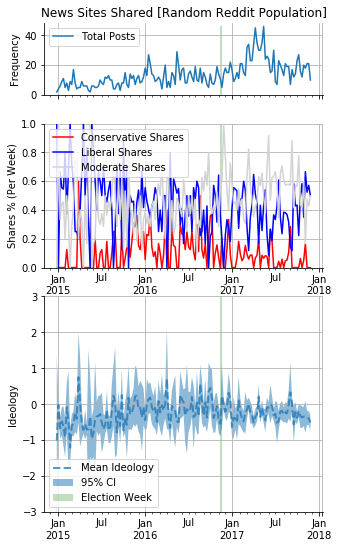

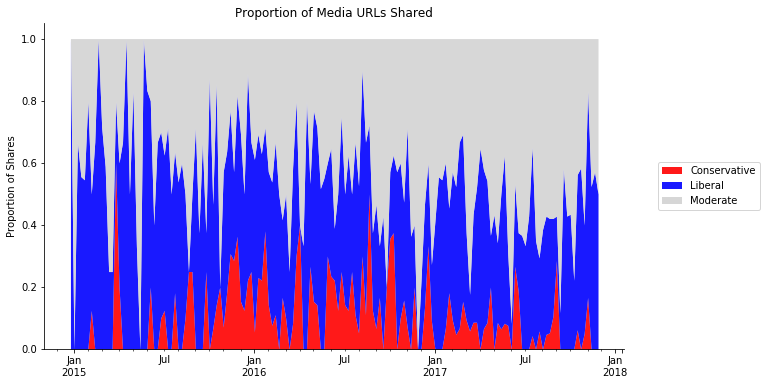

In [22]:

x, y_values, mean_ideo, labels = aggregate_timeseries(scored_random_links_df, freq=freq_level)

line_plot(x, y_values, color = iter(cmap_),
          labels=labels,
          means=mean_ideo, 
          title='News Sites Shared [Random Reddit Population]',
#           freq_lim=(0, 5000),
          figsize=(5,9),
          savefig="reddit_random_lineplot.pdf",
         )

porportion(x, y_values, "zero", 
           cmap=cmap_, 
           labels=labels,
           title="Proportion of Media URLs Shared",
          savefig="reddit_random_proportion.pdf",
          )


# # Plot number of unique users per day
# merged_w_scores.index = pd.to_datetime(merged_w_scores["tweet.created_at"])
# weekly_users = merged_w_scores.resample("w")["user.id"].nunique()
# fig, ax = plt.subplots(figsize=(16,6))
# ax.plot(weekly_users.index, weekly_users.values, label="Unique Users")

# # create legend
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# # Hide the right and top spines
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# # Only show ticks on the left and bottom spines
# ax.yaxis.set_ticks_position('left')
# ax.xaxis.set_ticks_position('bottom')

# ax.set_ylabel("Unique Users Per Day")
# plt.grid()
# plt.show()

Conservative (21726, 9)
Liberal (39127, 9)
Moderate (42820, 9)


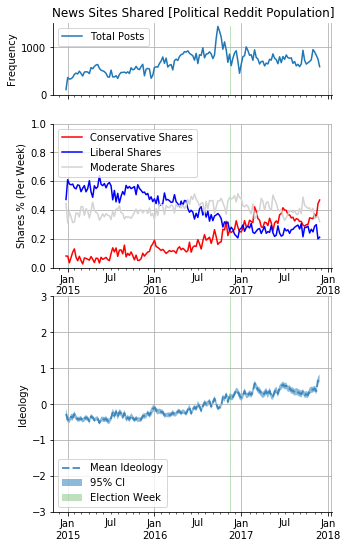

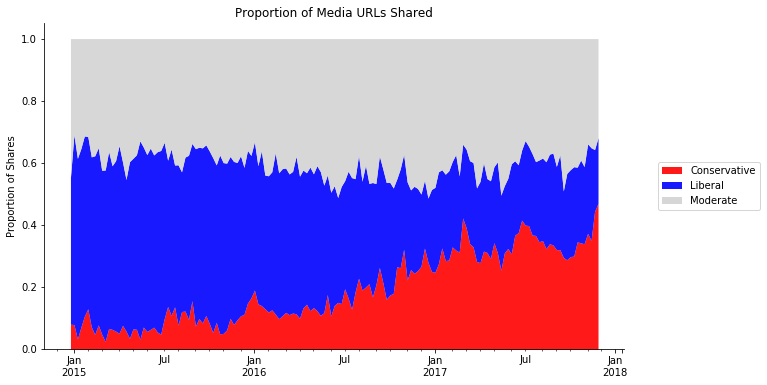

In [23]:

x, y_values, mean_ideo, labels = aggregate_timeseries(scored_political_links_df, freq=freq_level)

line_plot(x, y_values, color = iter(cmap_),
          labels=labels,
          means=mean_ideo, 
          title='News Sites Shared [Political Reddit Population]',
#           freq_lim=(0, 5000),
          figsize=(5,9),
          savefig="reddit_political_lineplot.pdf",
         )

porportion(x, y_values, "zero", 
           cmap=cmap_, 
           labels=labels,
           title="Proportion of Media URLs Shared",
          savefig="reddit_political_proportion.pdf",
          )

Conservative (454, 9)
Liberal (1184, 9)
Moderate (1084, 9)


/home/clb617/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide


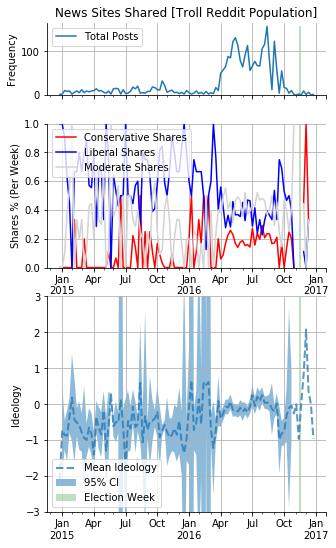

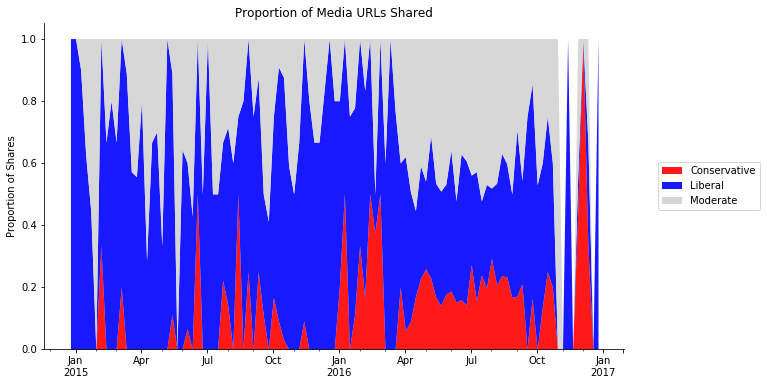

In [24]:
scored_troll_links_timed_df = scored_troll_links_df[scored_troll_links_df.date < datetime.datetime(2017,1,1)]
x, y_values, mean_ideo, labels = aggregate_timeseries(scored_troll_links_timed_df, freq=freq_level)

line_plot(x, y_values, color = iter(cmap_),
          labels=labels,
          means=mean_ideo, 
          title='News Sites Shared [Troll Reddit Population]',
#           freq_lim=(0, 5000),
          figsize=(5,9),
          savefig="reddit_troll_lineplot.pdf",
         )

porportion(x, y_values, "zero", 
           cmap=cmap_, 
           labels=labels,
           title="Proportion of Media URLs Shared",
          savefig="reddit_troll_proportion.pdf",
          )

# Analyze Differences Among Populations

How do political, random, and troll users behave in terms of URL sharing, and how different are they?

In [28]:
scored_links_df_rand = scored_random_links_df
scored_links_df_poli = scored_political_links_df
scored_links_df_ira = scored_troll_links_df

In [29]:
domains = sorted(mediascores_df.media_org)

In [33]:
def links_df_to_shares(links_df, domains):
    user_shares = []

    for user,user_posts in links_df.groupby("user_name"):
        local_tld_counts = dict(user_posts["tld"].value_counts().items())
        local_vector = [local_tld_counts.get(x, 0) for x in domains]
        user_shares.append([user] + local_vector)

    return pd.DataFrame(user_shares, columns=["user_name"] + domains)

user_tld_links_df_rand = links_df_to_shares(scored_links_df_rand, domains)
user_tld_links_df_poli = links_df_to_shares(scored_links_df_poli, domains)
user_tld_links_df_ira = links_df_to_shares(scored_links_df_ira, domains)

In [36]:
user_links_mat_rand = sklearn.preprocessing.normalize(user_tld_links_df_rand[domains], norm="l1", axis=1)
user_links_mat_poli = sklearn.preprocessing.normalize(user_tld_links_df_poli[domains], norm="l1", axis=1)
user_links_mat_ira = sklearn.preprocessing.normalize(user_tld_links_df_ira[domains], norm="l1", axis=1)

In [44]:
np.save("reddit_norm_share_rand", user_links_mat_rand)
np.save("reddit_norm_share_poli", user_links_mat_poli)
np.save("reddit_norm_share_ira", user_links_mat_ira)

In [51]:
rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(user_links_mat_rand, user_links_mat_rand)
poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(user_links_mat_poli, user_links_mat_poli)
rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(user_links_mat_rand, user_links_mat_poli)
ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(user_links_mat_ira, user_links_mat_rand)
ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(user_links_mat_ira, user_links_mat_poli)
ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(user_links_mat_ira, user_links_mat_ira)

rand_rand_sim_avg = (np.sum(rand_rand_sim, axis=1) - 1) / (user_links_mat_rand.shape[0] - 1)
poli_poli_sim_avg = (np.sum(poli_poli_sim, axis=1) - 1) / (user_links_mat_poli.shape[0] - 1)
rand_poli_sim_avg = (np.sum(rand_poli_sim, axis=1) - 1) / (user_links_mat_poli.shape[0] - 1)
ira_rand_sim_avg = (np.sum(ira_rand_sim, axis=1) - 1) / (user_links_mat_rand.shape[0] - 1)
ira_poli_sim_avg = (np.sum(ira_poli_sim, axis=1) - 1) / (user_links_mat_poli.shape[0] - 1)
ira_ira_sim_avg = (np.sum(ira_ira_sim, axis=1) - 1) / (user_links_mat_ira.shape[0] - 1)

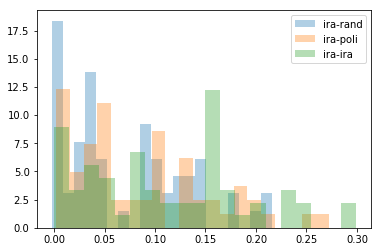

In [52]:
# plt.hist(rand_rand_sim_avg, bins=20, density=True, alpha=0.35, label="rand-rand")
# plt.hist(rand_poli_sim_avg, bins=20, density=True, alpha=0.35, label="rand-poli")
plt.hist(ira_rand_sim_avg, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(ira_poli_sim_avg, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(ira_ira_sim_avg, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.legend()
plt.show()

In [53]:
print("Random->Random:", rand_rand_sim_avg.mean(), rand_rand_sim_avg.std())
print("Random->Poli:", rand_poli_sim_avg.mean(), rand_poli_sim_avg.std())
print("Poli->Poli:", poli_poli_sim_avg.mean(), poli_poli_sim_avg.std())
print("IRA->Random:", ira_rand_sim_avg.mean(), ira_rand_sim_avg.std())
print("IRA->Political:", ira_poli_sim_avg.mean(), ira_poli_sim_avg.std())
print("IRA->IRA:", ira_ira_sim_avg.mean(), ira_ira_sim_avg.std())

Random->Random: 0.06586844454618453 0.04968090722350917
Random->Poli: 0.07042354758481385 0.052684936941060065
Poli->Poli: 0.08787621010376022 0.056436440528780676
IRA->Random: 0.07116252338059281 0.06048073988211862
IRA->Political: 0.0854336762720633 0.06829161435093294
IRA->IRA: 0.11271185306506606 0.07889705058354905


In [54]:
twitter_links_mat_rand = np.load("twitter_norm_share_rand.npy")
twitter_links_mat_poli = np.load("twitter_norm_share_poli.npy")
twitter_links_mat_ira = np.load("twitter_norm_share_ira.npy")

In [55]:
r2t_sim_rand = sklearn.metrics.pairwise.cosine_similarity(user_links_mat_rand, twitter_links_mat_rand)
r2t_sim_poli = sklearn.metrics.pairwise.cosine_similarity(user_links_mat_poli, twitter_links_mat_poli)
r2t_sim_ira = sklearn.metrics.pairwise.cosine_similarity(user_links_mat_ira, twitter_links_mat_ira)

r2t_sim_avg_rand = (np.sum(r2t_sim_rand, axis=1) - 1) / (twitter_links_mat_rand.shape[0] - 1)
r2t_sim_avg_poli = (np.sum(r2t_sim_poli, axis=1) - 1) / (twitter_links_mat_poli.shape[0] - 1)
r2t_sim_avg_ira = (np.sum(r2t_sim_ira, axis=1) - 1) / (twitter_links_mat_ira.shape[0] - 1)

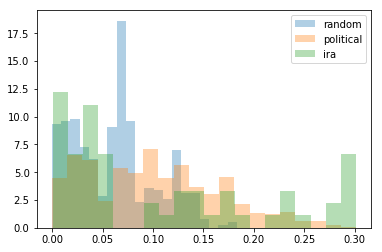

In [56]:
plt.hist(r2t_sim_avg_rand, bins=20, density=True, alpha=0.35, label="random")
plt.hist(r2t_sim_avg_poli, bins=20, density=True, alpha=0.35, label="political")
plt.hist(r2t_sim_avg_ira, bins=20, density=True, alpha=0.35, label="ira")

plt.legend()
plt.show()

In [57]:
print("Random:", r2t_sim_avg_rand.mean(), r2t_sim_avg_rand.std())
print("Political:", r2t_sim_avg_poli.mean(), r2t_sim_avg_poli.std())
print("IRA:", r2t_sim_avg_ira.mean(), r2t_sim_avg_ira.std())

Random: 0.061703020830908485 0.04084832953747314
Political: 0.10138705617202061 0.06510011428963461
IRA: 0.1078161146284952 0.09973348010208456


# Analyze Troll Ideology

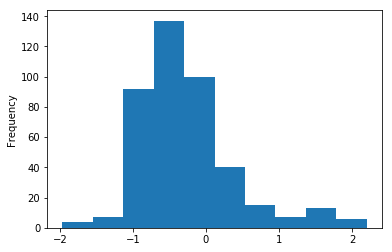

In [33]:
scored_random_links_df.groupby("user_name").describe()["zeta"]["mean"].plot.hist()

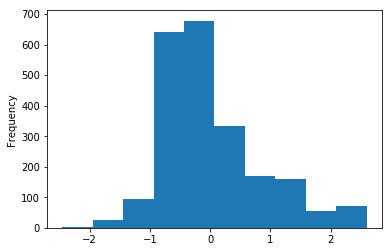

In [34]:
scored_political_links_df.groupby("user_name").describe()["zeta"]["mean"].plot.hist()

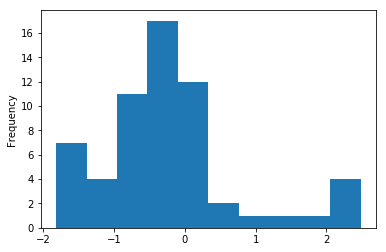

In [35]:
scored_troll_links_df.groupby("user_name").describe()["zeta"]["mean"].plot.hist()

In [36]:
ideologies_random = scored_random_links_df.groupby("user_name").describe()["zeta"]["mean"]
ideologies_political = scored_political_links_df.groupby("user_name").describe()["zeta"]["mean"]
ideologies_trolls = scored_troll_links_df.groupby("user_name").describe()["zeta"]["mean"]

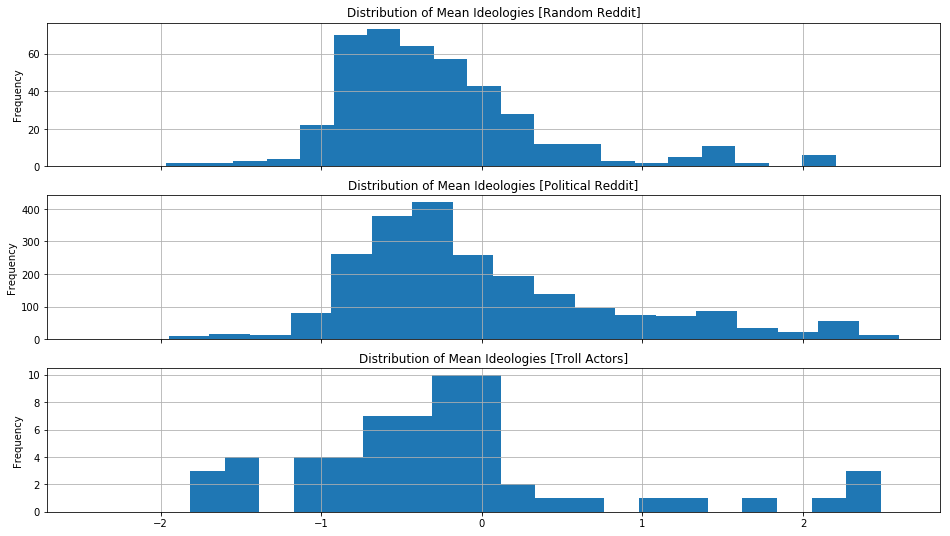

In [37]:
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2, sharex=ax1)
ax3 = fig.add_subplot(3,1,3, sharex=ax1)

ideologies_random.plot.hist(bins=20, ax=ax1)
ideologies_political.plot.hist(bins=20, ax=ax2)
ideologies_trolls.plot.hist(bins=20, ax=ax3)

ax1.set_title("Distribution of Mean Ideologies [Random Reddit]")
ax2.set_title("Distribution of Mean Ideologies [Political Reddit]")
ax3.set_title("Distribution of Mean Ideologies [Troll Actors]")

ax1.grid()
ax2.grid()
ax3.grid()

plt.show()

Left-Leaning Count: 44
Right-Leaning Count: 16
Conservative (440, 9)
Liberal (1199, 9)
Moderate (1074, 9)


/home/clb617/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide


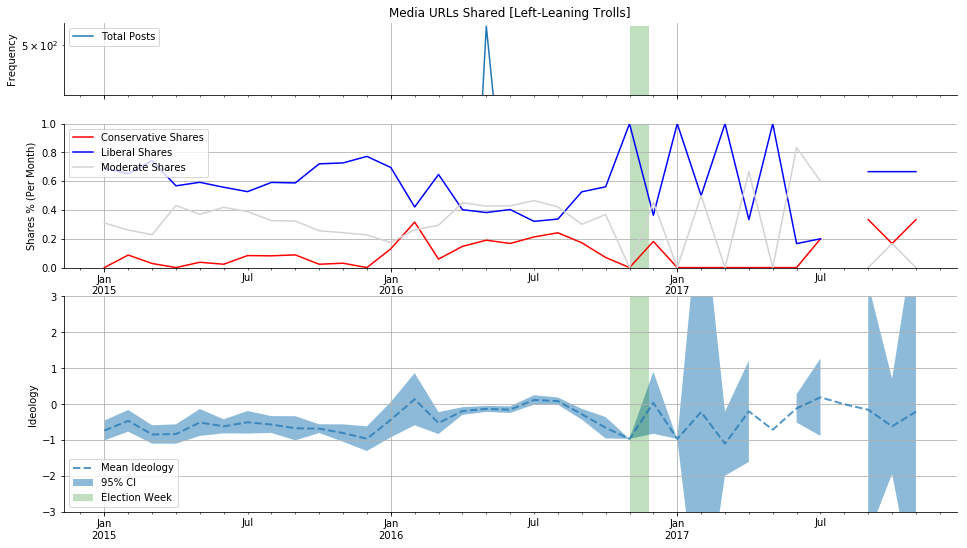

Conservative (18, 9)
Liberal (4, 9)
Moderate (22, 9)


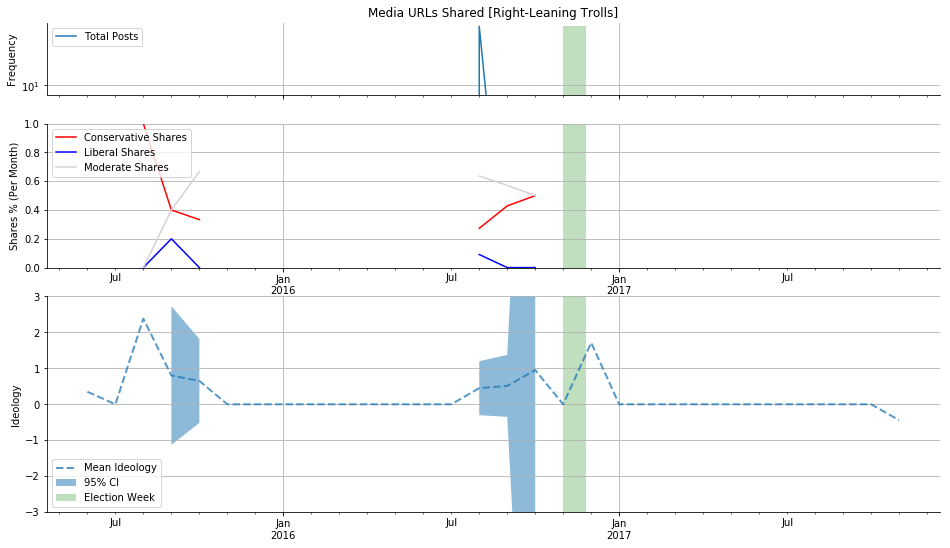

In [38]:
left_trolls = ideologies_trolls[ideologies_trolls < 0].index
right_trolls = ideologies_trolls[ideologies_trolls > 0].index

print("Left-Leaning Count:", left_trolls.shape[0])
print("Right-Leaning Count:", right_trolls.shape[0])

left_troll_df = scored_troll_links_df[scored_troll_links_df["user_name"].isin(left_trolls)]
right_troll_df = scored_troll_links_df[scored_troll_links_df["user_name"].isin(right_trolls)]

# Left Trolls
x, y_values, mean_ideo, labels = aggregate_timeseries(left_troll_df, freq="M")
line_plot(x, y_values, color = iter(cmap_),
          labels=labels,
          means=mean_ideo, 
          title='Media URLs Shared [Left-Leaning Trolls]',
#           savefig="reddit_troll_lineplot.pdf",
         )


x, y_values, mean_ideo, labels = aggregate_timeseries(right_troll_df, freq="M")
line_plot(x, y_values, color = iter(cmap_),
          labels=labels,
          means=mean_ideo, 
          title='Media URLs Shared [Right-Leaning Trolls]',
#           savefig="reddit_troll_lineplot.pdf",
         )